# Ouroboros - Mecânicas autobalanceadas de nerfs / buffs de itens em jogos por meio de modelos Lotka-Volterra

## Introdução

O Modelo de Lotka-Volterra é um par de equações diferenciais que descreve a dinâmica de duas populações interagindo, tipicamente uma presa e um predador, mostrando ciclos oscilatórios: o aumento de presas leva ao aumento de predadores, que por sua vez reduz as presas, levando à queda dos predadores, e assim por diante, mas assume alimento ilimitado para presas e que predadores morrem sem presas, servindo de base para modelos ecológicos mais complexos, com aplicações também em economia e química:

$$
\begin{cases}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{cases}
$$

No sistema de EDOs acima, $x$ é a população de presas e $y$ é a população de predadores.

Na concepção inicial do modelo, assume-se que exista suprimento de alimentos infinitos para presas, o que nem sempre é verdade, portanto, é comum limitar o crescimento da população x de presas à uma capacidade de suporte K, como demonstrado abaixo:

$$
\begin{cases}
\frac{dx}{dt} = \alpha x \left(1 - \frac{x}{K} \right) - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{cases}
$$

## O Ecossistema Digital: A Aplicação de Modelos Biológicos no Balanceamento de Jogos

A manutenção do equilíbrio competitivo em jogos eletrônicos modernos enfrenta um desafio contínuo: a velocidade com que os jogadores identificam e exploram estratégias dominantes pode superar a capacidade dos desenvolvedores de realizar ajustes manuais. Esse descompasso pode ocasionar períodos de estagnação no jogo, onde a diversidade de escolhas é sufocada pela onipresença de itens desproporcionalmente fortes. Para solucionar essa ineficiência, a aplicação de modelos de dinâmica populacional, especificamente as equações de Lotka-Volterra, oferece uma alternativa robusta, transformando o balanceamento estático em um ecossistema autônomo e auto-regulável.

Nessa perspectiva, estabelece-se uma analogia funcional onde a efetividade de um item (dano ou utilidade) comporta-se como a população de "presas", enquanto a frequência de escolha pelos jogadores (pick rate) atua como a população de "predadores". A lógica subjacente é a de um ciclo de feedback negativo: itens subutilizados, livres de "predação", têm sua efetividade aumentada pelo sistema para atrair interesse. Inversamente, quando um item se populariza excessivamente, a alta densidade de predadores aciona mecanismos de redução de efetividade (nerfs), simulando a escassez de recursos causada pela superpopulação, o que força os jogadores a migrarem para outras estratégias.

Entretanto, a aplicação bruta do modelo de Lotka-Volterra pode ser insuficiente se não considerar a real quantidade de picks, bem como, a pressão da quantidade de picks sobre as taxas de reprodução das presas (recomposição da efetividade dos itens). Desta forma, é proposto um modelo Lotka-Volterra adaptado para o auto-balanceamento das mecânicas de competitividade em jogos que leve em consideração:

1. Pressão da população de predadores (picks) sobre a taxa reprodutiva das presas (efetividade), ou seja, quanto maior a quantidade de predadores, mais difícil é para as presas se reproduzirem;
2. Adição de um termo de correção (nudging) para melhor modelar as taxas de variação das populações de predadores (picks) à partir dos usos de itens realmente realizados pelos jogadores ($y_{\text{obs}}$).

Destarte, o seguinte sistema de equações diferenciais é proposto:

$$
\begin{cases}
\frac{dx}{dt} = \alpha x \left(1 - \frac{x}{K} \right) - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y + \epsilon \left(y_{\text{obs}} - y\right) \\
\alpha = \alpha_{0} e^{- \zeta y}
\end{cases}
$$

É possível observar que a taxa de reprodução da população de presas é cada vez menor à medida em que a população de picks aumenta, o que caracteriza a pressão exercida pelos predadores nas condições de recomposição da população de presas - quanto mais predadores, mais difícil é para se reproduzir.

## Proposta de Aplicação Prática - Nerf / Buff de tacos do jogo 8-ball pool mobile de Android

No jogo 8-ball pool do Android, os jogadores dispõem de uma variedade de instrumentos (tacos), cujos atributos intrínsecos influenciam diretamente a física da partida. Dentre esses atributos, a precisão da tacada — visualmente representada pela extensão e fidelidade da linha guia de mira — destaca-se como o fator determinante para a vantagem competitiva.

Neste contexto, a modelagem biológica é transposta para a mecânica de equipamentos compartilhados. A efetividade do taco, especificamente o seu coeficiente de precisão, assume o papel da população de "presas" (x). Paralelamente, a taxa de utilização desse modelo específico de taco pela base de jogadores constitui a população de "predadores" (y). A premissa fundamental é que a precisão de um equipamento não deve ser uma constante imutável, mas um recurso dinâmico que reage à demanda do servidor.

Operacionalmente, o sistema monitora o compartilhamento de modelos de tacos entre os usuários. Equipamentos que caem no esquecimento (baixo y) experimentam um incremento gradual em sua precisão (aumento de x via α dinâmico), tornando-se progressivamente mais eficientes para "fisgar" novos usuários. Em contrapartida, a popularização massiva de um único modelo de taco exacerba o consumo desse recurso; o sistema interpreta a alta frequência de uso como uma superpopulação de predadores, ativando simultaneamente o termo de mitigação da taxa de reprodução das presas (e−ζy) e o decréscimo da efetividade pelo encontro com a população de predadores (−βxy). Isso resulta em uma degradação sutil, porém perceptível, da linha guia de mira, simulando um "desgaste" pela superexposição, validando o modelo como uma ferramenta eficaz para evitar a homogeneização dos equipamentos.

Adicionalmente, o modelo apresenta implicações estratégicas para a economia do jogo e a retenção de usuários. Ao introduzir volatilidade no desempenho, incentiva-se a diversificação do arsenal mesmo entre jogadores premium, transformando a compra de recursos em uma busca contínua por novas estratégias eficazes, em vez da estagnação em um único item dominante. Simultaneamente, o sistema atua como um mecanismo de nivelamento orgânico: jogadores iniciantes ou casuais ganham acesso a estratégias de alta eficiência (tacos pouco utilizados e, portanto, maximizados pelo sistema), permitindo-lhes competir com maior paridade contra veteranos e grupos exclusivos que insistem em utilizar o "meta" saturado e desgastado.

## Simulações Experimentais:


Caso 1: Um taco que tenha efetividade inicial de 100, capacidade de suporte de 200, taxa base reprodutiva alpha0 de 1.5, zeta de 0.005, beta de 0.4, delta de 0.1, gamma de 0.15, epsilon de 0.05, y_obs = y_t e y(0) = 20


Caso 2. Igual ao caso 1, exceto por y_obs. que é uma sigmoidal deslocada para a direita que corta o eixo y em 10, aumenta até 200, fica nesse valor por ao menos 20 periodos de tempo e depois decai exponencialmente até 50, passando a oscilar de forma senoidal entre 100 e 0. 

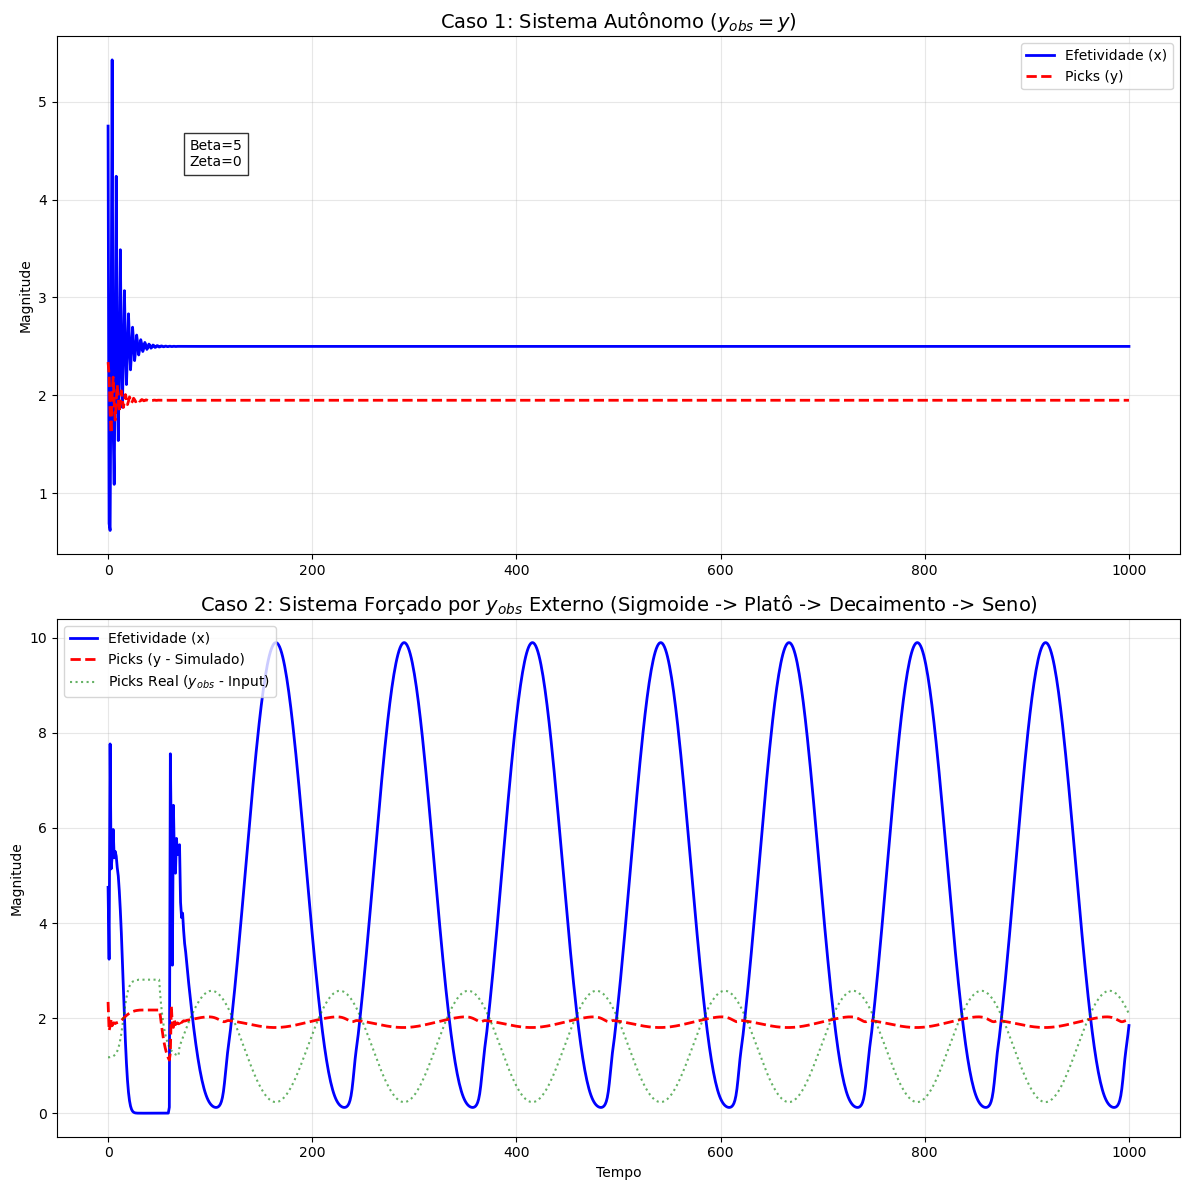

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- Parâmetros Globais (Baseados no seu pedido) ---
K = 100.0        # Capacidade de Suporte
alpha0 = 10      # Taxa reprodutiva base
zeta = 0         # Fator de amortecimento de Alpha (Ouroboros)
beta = 5         # Taxa de predação (Nerf por uso)
delta = 0.1      # Conversão de uso
gamma = 0.25     # Taxa de decaimento natural
epsilon = 0.85   # Força do Nudging
x0 = gamma / delta
x0 += 9e-1 * x0
y0 = alpha0 / beta * (1 - gamma / (delta * K))
y0 += 2e-1 * y0

# --- Funções Auxiliares para o Caso 2 ---
def sigmoid(t, start_val, end_val, center, steepness):
    return start_val + (end_val - start_val) / (1 + np.exp(-steepness * (t - center)))

def decay_exponential(t, t_start, start_val, end_val, rate):
    return end_val + (start_val - end_val) * np.exp(-rate * (t - t_start))

# --- Definição de y_obs (O Comportamento Externo) ---
def get_y_obs_case2(t):
    # Fases temporais arbitradas para caber na simulação
    # t < 30: Subida Sigmoidal
    # 30 <= t < 50: Platô (20 períodos)
    # 50 <= t < 70: Decaimento Exponencial
    # t >= 70: Oscilação Senoidal
    
    if t < 30:
        # Sigmoidal deslocada que começa em ~10 e vai até 20
        # Ajustado para cortar y em y0/2 aprox e subir
        return sigmoid(t, y0/2, 1.2*y0, 15, 0.4) 
    elif t < 50:
        return 1.2*y0
    elif t < 70:
        return decay_exponential(t, 50, 1.2*y0, y0/2, 0.2)
    else:
        # Oscila entre 0.6 y0 e 1.1 y0 (Centro 3*y0/5, Amplitude y0/2)
        return 3*y0/5 + y0/2 * np.sin(0.05 * (t - 70))

# --- O Modelo Diferencial ---
def ouroboros_simulation(z, t, case_type):
    x, y = z
    x, y = max(1e-6, x), max(1e-6, y) # Proteção numérica
    
    # Define y_obs baseado no caso
    if case_type == 1:
        y_obs = y # O enunciado diz y_obs = y(t), anulando o termo epsilon
    else:
        y_obs = get_y_obs_case2(t)
    
    # 1. Alpha Dinâmico
    current_alpha = alpha0 * np.exp(-zeta * y)
    
    # 2. Equações
    dxdt = current_alpha * x * (1 - x/K) - beta * x * y
    dydt = delta * x * y - gamma * y + epsilon * (y_obs - y)
    
    return [dxdt, dydt]

# --- Configuração do Tempo ---
t = np.linspace(0, 1000, 1001)
initial_state = [x0, y0]

# --- Execução das Simulações ---
# Caso 1:
sol_case1 = odeint(ouroboros_simulation, initial_state, t, args=(1,))
x1, y1 = sol_case1[:, 0], sol_case1[:, 1]

# Caso 2:
sol_case2 = odeint(ouroboros_simulation, initial_state, t, args=(2,))
x2, y2 = sol_case2[:, 0], sol_case2[:, 1]
# Gera a série de y_obs para plotar junto e validar visualmente
y_obs_series = [get_y_obs_case2(ti) for ti in t]

# --- Plotagem dos Resultados ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot Caso 1
ax1.set_title("Caso 1: Sistema Autônomo ($y_{obs} = y$)", fontsize=14)
ax1.plot(t, x1, 'b-', label='Efetividade (x)', linewidth=2)
ax1.plot(t, y1, 'r--', label='Picks (y)', linewidth=2)
ax1.set_ylabel("Magnitude")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.text(80, max(x1)*0.8, f"Beta={beta}\nZeta={zeta}", bbox=dict(facecolor='white', alpha=0.8))

# Plot Caso 2
ax2.set_title("Caso 2: Sistema Forçado por $y_{obs}$ Externo (Sigmoide -> Platô -> Decaimento -> Seno)", fontsize=14)
ax2.plot(t, x2, 'b-', label='Efetividade (x)', linewidth=2)
ax2.plot(t, y2, 'r--', label='Picks (y - Simulado)', linewidth=2)
ax2.plot(t, y_obs_series, 'g:', label='Picks Real ($y_{obs}$ - Input)', alpha=0.6, linewidth=1.5)
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Tempo")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

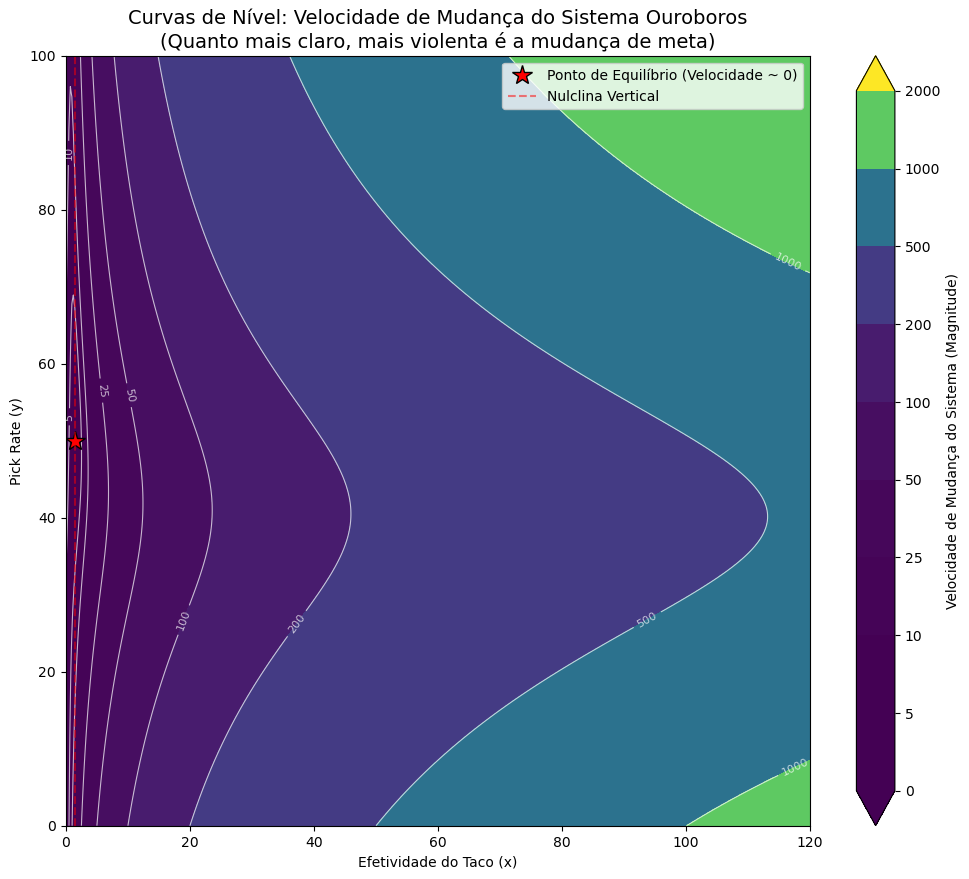

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parâmetros do Modelo (Caso 1) ---
K = 100000.0     
alpha0 = 10.0    
zeta = 0.00001   
beta = 0.2       
delta = 0.1      
gamma = 0.15     

# --- 2. Criação da Malha (Grid) ---
# Vamos focar na região onde a ação acontece: entre a efetividade inicial (100) e o equilíbrio (1.5)
x_vals = np.linspace(0, 120, 500)
y_vals = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x_vals, y_vals)

# --- 3. Cálculo do Campo Escalar (Velocidade do Sistema) ---
# Calculamos as derivadas em cada ponto do mapa
# dx/dt
alpha_dyn = alpha0 * np.exp(-zeta * Y)
dX = alpha_dyn * X * (1 - X/K) - beta * X * Y

# dy/dt (Autônomo: y_obs = y, então epsilon anula)
dY = delta * X * Y - gamma * Y

# Magnitude da Velocidade (Speed)
# Z é a "altura" do nosso terreno. Quanto maior Z, mais rápida a mudança.
Z = np.sqrt(dX**2 + dY**2)

# --- 4. Plotagem das Curvas de Nível (Contour Plot) ---
fig, ax = plt.subplots(figsize=(12, 10))

# A. Curvas de Nível Preenchidas (O "Mapa de Calor")
# Usamos níveis logarítmicos ou específicos para ver melhor os detalhes perto do zero
levels = np.linspace(0, Z.max(), 30)
# Vamos focar em níveis menores para ver o "vale" do equilíbrio
custom_levels = [0, 5, 10, 25, 50, 100, 200, 500, 1000, 2000]

contour_filled = ax.contourf(X, Y, Z, levels=custom_levels, cmap='viridis', extend='both')
fig.colorbar(contour_filled, label='Velocidade de Mudança do Sistema (Magnitude)')

# B. Linhas de Contorno (As "Curvas de Nível" propriamente ditas)
contours = ax.contour(X, Y, Z, levels=custom_levels, colors='white', linewidths=0.8, alpha=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')

# C. Ponto de Equilíbrio (Onde Z = 0)
fixed_x = gamma / delta # 1.5
fixed_y = 50.0 # Aproximado
ax.plot(fixed_x, fixed_y, 'r*', markersize=15, markeredgecolor='black', label='Ponto de Equilíbrio (Velocidade ~ 0)')

# D. Adicionar a Nulclina para referência (Onde dy/dt = 0)
ax.axvline(fixed_x, color='red', linestyle='--', alpha=0.5, label='Nulclina Vertical')

# Ajustes
ax.set_title('Curvas de Nível: Velocidade de Mudança do Sistema Ouroboros\n(Quanto mais claro, mais violenta é a mudança de meta)', fontsize=14)
ax.set_xlabel('Efetividade do Taco (x)')
ax.set_ylabel('Pick Rate (y)')
ax.legend()
ax.grid(False) # Grid desligado para não poluir as curvas

plt.show()

## Caso 2 - Delta aumenta probabilísticamente, conforme x é maior, maior é a chance de y reproduzir mais

Propusemos esse caso 2, pois, podemos ver que o sistema 1 entrou em equilíbrio muito rapidamente e dali pra frente já não houveram mais variações de picks ou de efetividade dos itens. Agora além de alpha ser menor quando a população de predadores for maior, o fator de reprodução delta tem uma probabilidade $\frac{x}{K} \times \text{hype\_sensibility}$ de aumentar quando aumenta-se a população de presas, o que faz sentido, pois, quanto mais presas, os predadores tem mais alimentos para se reproduzirem.

In [127]:
np.random.seed(42) # for reproductibility

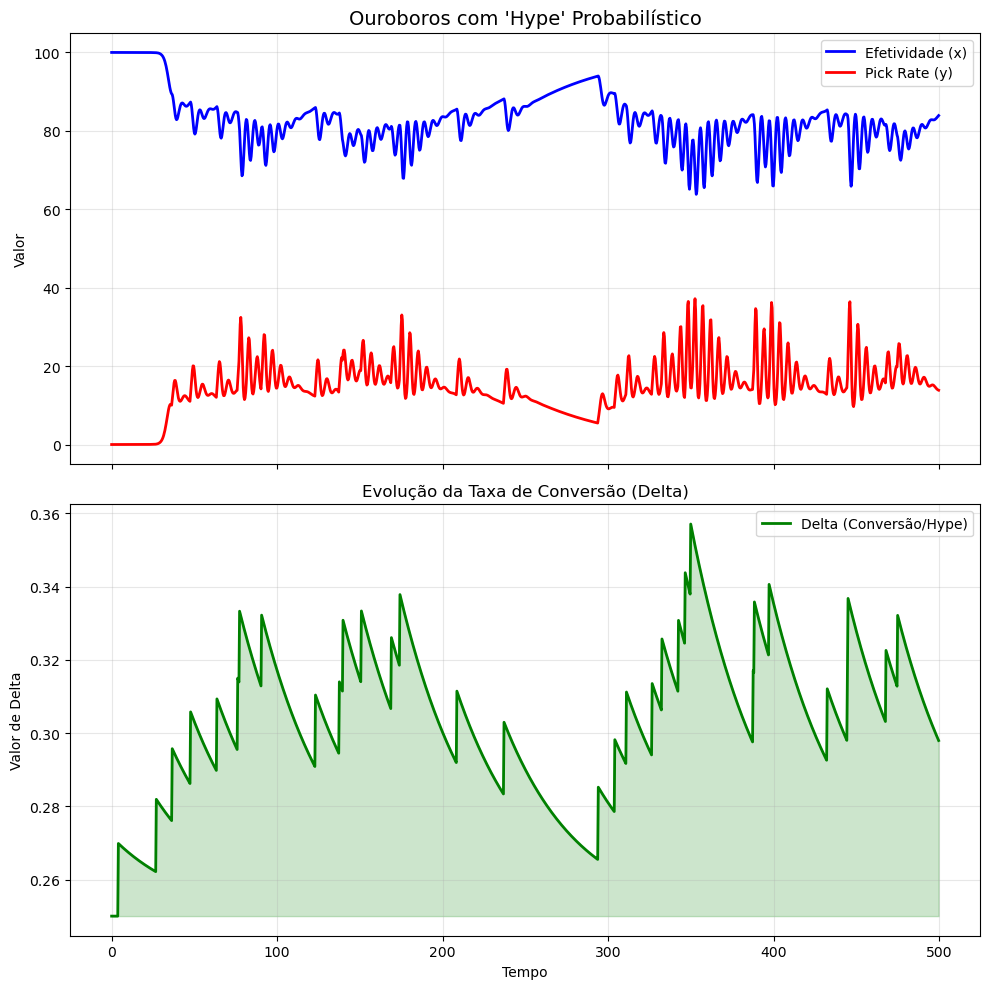

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parâmetros ---
# Populações Iniciais
delta = 0.25 # Taxa de conversão inicial (Base)

# Parâmetros Fixos
K = 100.0        # Capacidade de suporte
alpha0 = 3.8     # Taxa de crescimento base
zeta = 0.005     # Pressão sobre alpha
beta = 0.04      # Taxa de Nerf (predação)
gamma = 25       # Taxa de abandono
epsilon = 0.0    # Vamos desligar o nudging externo para ver só a dinâmica interna

# --- Parâmetros do "Hype" (Delta Dinâmico) ---
delta_base = 0.25       # O valor normal de conversão
delta_max = 0.75        # O valor máximo quando viraliza
hype_sensitivity = 0.03 # Chance de aumentar baseada em x (Probabilidade)
hype_decay = 0.08       # Quão rápido o delta volta ao normal

# --- Configuração do Tempo (Método de Euler) ---
dt = 0.1                # Tamanho do passo de tempo
steps = 5000           # Quantidade de passos
time = np.arange(0, steps * dt, dt * np.log10(steps))

# Arrays para guardar o histórico
history_x = []
history_y = []
history_delta = []

x = (gamma / delta) # Efetividade (Começa alta para testar o hype)
y = alpha0/beta * (1 - gamma/(delta * K))    # Pick Rate (Começa baixo)

# --- Loop de Simulação (Game Loop) ---
for t in time:
    # 1. Guarda estado atual
    history_x.append(x)
    history_y.append(y)
    history_delta.append(delta)
    
    # 2. Lógica Probabilística para o Delta (Sua ideia)
    # A chance de aumentar depende de quão forte é o item (x) em relação a K
    # Se x é 80 e K é 100, chance alta. Se x é 10, chance baixa.
    chance_viralizar = (x / K) * hype_sensitivity
    
    # Rola o dado (0 a 1)
    if np.random.rand() < chance_viralizar:
        # HYPE ACONTECEU: Delta aumenta!
        delta += 0.02
    
    # Teto e Relaxamento do Delta
    # Delta não pode passar do máximo
    delta = min(delta, delta_max) 
    # Delta decai naturalmente para a base (o hype esfria)
    delta = delta - hype_decay * (delta - delta_base) * dt
    
    # 3. Equações Diferenciais (Ouroboros)
    # Alpha dinâmico
    current_alpha = alpha0 * np.exp(-zeta * y)
    
    # Derivadas
    dxdt = current_alpha * x * (1 - x/K) - beta * x * y
    dydt = delta * x * y - gamma * y # Usamos o delta atualizado aqui!
    
    # 4. Atualização de Euler (x = x + dx * dt)
    x += dxdt * dt
    y += dydt * dt
    
    # Proteção para não ficar negativo
    x = max(1e-5, x)
    y = max(1e-5, y)

# --- Plotagem ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Gráfico 1: Populações
ax1.set_title("Ouroboros com 'Hype' Probabilístico", fontsize=14)
ax1.plot(time, history_x, 'b-', label='Efetividade (x)', linewidth=2)
ax1.plot(time, history_y, 'r-', label='Pick Rate (y)', linewidth=2)
ax1.set_ylabel("Valor")
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Gráfico 2: O Comportamento do Delta
ax2.set_title("Evolução da Taxa de Conversão (Delta)", fontsize=12)
ax2.plot(time, history_delta, 'g-', label='Delta (Conversão/Hype)', linewidth=2)
ax2.fill_between(time, delta_base, history_delta, color='green', alpha=0.2)
ax2.set_ylabel("Valor de Delta")
ax2.set_xlabel("Tempo")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()